# **Second assignment**: Laura Carralero and Daniel Losada

## 0. Python libraries and input data

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from joblib import dump


In [2]:
NIA = 100544178
xx = 7+8
xx
#We set the NIA as the seed over the whole project
np.random.seed(NIA)

In [3]:
#We load the dataset 
df = pd.read_csv('./datasets/attrition_availabledata_15.csv.gz', compression='gzip')
df_test = pd.read_csv('./datasets/attrition_competition_15.csv.gz', compression='gzip')

# 1. EDA

For this section we have defined a python class to understand and explore the structure of the dataset. In this class the functions we are defining give us a first view of the top rows of the dataset, which will allow us to understand which type of variables the dataset contains. Additionally, other functions related to counting missing values in the features and the number of unique values in each variable are included. 

In [ ]:
class DatasetInspector(BaseEstimator, TransformerMixin):
    def __init__(self, dataset=None):
        self.dataset = dataset

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        n_instances = len(X)
        print(f"\nNumber of instances: {n_instances}")
        
        n_features = X.shape[1]
        print(f"Number of features: {n_features}")
        
        constant_columns = [col for col in X.columns if X[col].nunique() == 1]
        print(f"Number of constant columns: {len(constant_columns)}")
        print(f"Columns with a single unique value: {constant_columns}")
        
        missing_data = X.isnull().sum().sum()
        print(f"Number of missing values: {missing_data}")
        
        return X

# Create the pipeline and use it on my dataset 
inspection_pipeline = Pipeline(steps=[
    ('inspector', DatasetInspector(dataset=df)) 
])


inspection_pipeline.fit_transform(df)



Number of instances: 2940
Number of features: 31
Number of constant columns: 3
Columns with a single unique value: ['EmployeeCount', 'Over18', 'StandardHours']
Number of missing values: 0


,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,...,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,6.628646,10.0,3.0,3.0,1.0,3.0,3.0,40.0,Travel_Frequently,Sales,...,Y,14.0,8.0,0.0,10.0,3.0,1.0,0.0,0.0,No
1,5.537753,19.0,3.0,3.0,3.0,2.0,3.0,21.0,Travel_Rarely,Human Resources,...,Y,12.0,8.0,1.0,1.0,2.0,1.0,0.0,0.0,Yes
2,6.114008,14.0,3.0,3.0,3.0,1.0,1.0,52.0,Travel_Rarely,Research & Development,...,Y,18.0,8.0,1.0,12.0,6.0,5.0,0.0,4.0,No
3,8.677896,17.0,2.0,3.0,1.0,3.0,3.0,41.0,Non-Travel,Research & Development,...,Y,15.0,8.0,2.0,10.0,2.0,8.0,0.0,7.0,No
4,7.970253,5.0,2.0,3.0,1.0,2.0,3.0,21.0,Travel_Frequently,Research & Development,...,Y,12.0,8.0,0.0,3.0,5.0,3.0,1.0,2.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,9.610108,12.0,3.0,3.0,3.0,4.0,1.0,51.0,Travel_Rarely,Research & Development,...,Y,12.0,8.0,1.0,11.0,2.0,10.0,1.0,0.0,No
2936,9.130345,7.0,3.0,3.0,2.0,3.0,3.0,29.0,Travel_Rarely,Sales,...,Y,12.0,8.0,0.0,5.0,2.0,3.0,0.0,2.0,Yes
2937,9.201354,9.0,2.0,3.0,4.0,1.0,3.0,36.0,Travel_Rarely,Research & Development,...,Y,12.0,8.0,0.0,15.0,2.0,12.0,5.0,7.0,No
2938,6.945580,15.0,3.0,3.0,1.0,2.0,3.0,55.0,Travel_Rarely,Research & Development,...,Y,11.0,8.0,0.0,37.0,5.0,10.0,7.0,7.0,No


From this output we can observe that the dataset consists on **2940 observations** and **31 columns**, where none of them has any **missing value**.  Furthermore, from these columns 3 of them can be dropped since they have a constant value, these are *EmployeeCount*, *Over18* and *StandardHour*.

Furthermore, this dataset overview helps us identify the **numerical and categorical** columns, which will be grouped in subsequent code sections.

In [5]:
target = 'Attrition'

In [6]:
identifier_cols = ['EmployeeID']
constant_cols = ['Over18', 'StandardHours']


In [7]:
numeric_columns = df.select_dtypes(include='number').columns.tolist()
print(numeric_columns)

categorical_columns = df.select_dtypes(include=['category', 'object']).columns.tolist()
print(categorical_columns)

# We check if all columns are classified
len(numeric_columns) + len(categorical_columns) == len(df.columns)

['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'Attrition']


True

## 1.1 Categorical variables

Now that we have separated the variables into numeric and categorical columns, we are going to explore in detail the categorical features.  The objective of this section is to analyze them and classify them into ordinal, for the ones that presents an order between classes, like *BusinessTravel*, binary, for *gender* and multiclass for the rest of categorical variables.

In [8]:
df[categorical_columns].nunique()

BusinessTravel    3
Department        3
EducationField    6
Gender            2
JobRole           9
MaritalStatus     3
Over18            1
Attrition         2
dtype: int64

We see how *JobRole* and *EducationField* have a **relatively high cardinality**.

In [9]:
df[categorical_columns].head()

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,Attrition
0,Travel_Frequently,Sales,Marketing,Male,Manufacturing Director,Single,Y,No
1,Travel_Rarely,Human Resources,Human Resources,Male,Laboratory Technician,Single,Y,Yes
2,Travel_Rarely,Research & Development,Life Sciences,Female,Healthcare Representative,Married,Y,No
3,Non-Travel,Research & Development,Life Sciences,Male,Manufacturing Director,Single,Y,No
4,Travel_Frequently,Research & Development,Medical,Female,Manufacturing Director,Single,Y,Yes


In [10]:
ordinal_columns = ['BusinessTravel']
binary_columns = ['Gender']
nominal_columns = list(set(categorical_columns) - set(ordinal_columns) - set(binary_columns) - {target})

len(categorical_columns) == len(ordinal_columns) + len(binary_columns) + len(nominal_columns) + 1  #+1 por el target

True

In [11]:
#We study the categories of the variables BusinessTravel: 
categorias_business_travel = df['BusinessTravel'].unique()
categorias_business_travel

array(['Travel_Frequently', 'Travel_Rarely', 'Non-Travel'], dtype=object)

## 1.2. Target distribution

The distribution of the target is **highly imbalanced**. The 83.87% of the employees are still working at the company, and just the 16.13% have left. Since the target is categorical, this is going to be a **classification problem**.

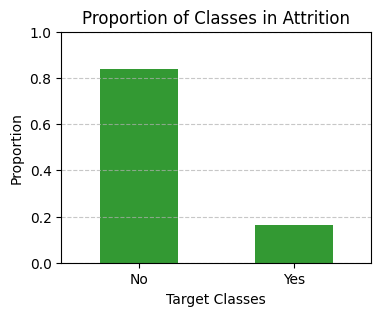

Target balance:
Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64


In [12]:
plt.figure(figsize=(4, 3))
df[target].value_counts(normalize=True).plot(kind='bar', color='green', alpha=0.8)
plt.title(f'Proportion of Classes in {target}')
plt.ylabel('Proportion')
plt.xlabel('Target Classes')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print target balance
print("Target balance:")
print(df[target].value_counts(normalize=True))

# 2. Setup 

For this section, before splitting the dataset into train and test, we must remove  the constant and id columns from the dataset.

In [13]:
df = df.drop(columns=identifier_cols + constant_cols)
df.head()

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,...,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,6.628646,10.0,3.0,3.0,1.0,3.0,3.0,40.0,Travel_Frequently,Sales,...,22380.0,6.0,14.0,0.0,10.0,3.0,1.0,0.0,0.0,No
1,5.537753,19.0,3.0,3.0,3.0,2.0,3.0,21.0,Travel_Rarely,Human Resources,...,53730.0,1.0,12.0,1.0,1.0,2.0,1.0,0.0,0.0,Yes
2,6.114008,14.0,3.0,3.0,3.0,1.0,1.0,52.0,Travel_Rarely,Research & Development,...,27590.0,9.0,18.0,1.0,12.0,6.0,5.0,0.0,4.0,No
3,8.677896,17.0,2.0,3.0,1.0,3.0,3.0,41.0,Non-Travel,Research & Development,...,26700.0,2.0,15.0,2.0,10.0,2.0,8.0,0.0,7.0,No
4,7.970253,5.0,2.0,3.0,1.0,2.0,3.0,21.0,Travel_Frequently,Research & Development,...,178750.0,1.0,12.0,0.0,3.0,5.0,3.0,1.0,2.0,Yes


In [14]:
def correct_column_array(df, columns):
    return [col for col in columns if col in df.columns]

ordinal_columns = correct_column_array(df, ordinal_columns)
binary_columns = correct_column_array(df, binary_columns)
nominal_columns = correct_column_array(df, nominal_columns)
numeric_columns = correct_column_array(df, numeric_columns)

#Specify order for the ordinal variable
ordinal_categories = [['Non-Travel', 'Travel_Rarely', 'Travel_Frequently']]  

## 2.1 Split data

We will split the data into training and test sets, with **80% of the data allocated for training and 20% for testing**.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=[target]), df[target], test_size=0.2, random_state=NIA, stratify=df[target])

For the next question, we have decided to use **5-fold cross-validation**.

# 3. Basic methods

For this section first we are going to define the preprocessor of the variables for them to be included in the pipelines of the algorithms. We are going to define two different preprocessors, each for each type of scaler for the numeric variables: the first one is going to have the standard scaler and the second one the minmax scaler. In this preprocessor, we are also going to encode the categorical variables. Then we are going to define the scorers to test the performance of the algorithms and the cross validation method chosen in the previous question. Afterwards, we will apply the different technics for our classification problem.

In [16]:
class BinaryEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.map(lambda x: 1 if x == 'Male' else 0).values

# Define transformations
## Categorical columns
ordinal_transformer = OrdinalEncoder(categories=ordinal_categories) #We need to specify the order of the categories 
binary_transformer = BinaryEncoder()  
nominal_transformer = OneHotEncoder(handle_unknown='ignore')  #Create dummy columns for each category
## Numerical columns
numeric_transformer_standard = StandardScaler() 

numeric_transformer_minmax = MinMaxScaler()

preprocessor_standard = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_transformer, ordinal_columns),
        ('binary', binary_transformer, binary_columns),
        ('nominal', nominal_transformer, nominal_columns),
        ('numeric', numeric_transformer_standard, numeric_columns)
    ]
)

preprocessor_minmax = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_transformer, ordinal_columns),
        ('binary', binary_transformer, binary_columns),
        ('nominal', nominal_transformer, nominal_columns),
        ('numeric', numeric_transformer_minmax, numeric_columns)
    ]
)

scorers = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'accuracy': make_scorer(accuracy_score)    
}

# Define stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=NIA)  #stratified: to keep the proportion of yes and no of the target

## 3.1. Dummy Classifier

This algorithm will predict the class for each observation by assigning it to the most frequent target class observed in the training data.

In [17]:

dummy = DummyClassifier(strategy='most_frequent', random_state=NIA)

# Combine preprocessing and dummy model in a pipeline
dummy_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_standard),
    ('dummy', dummy)
])

dummy_pipeline.fit(X_train, y_train)

y_pred_test = dummy_pipeline.predict(X_test)

# Compute balanced accuracy on the test set
dummy_test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_test)
print(f"Dummy test balanced accuracy: {dummy_test_balanced_accuracy:.2f}")

# Store results in a DataFrame
results_df = pd.DataFrame({
    'Model': ['DummyClassifier'],
    'Test Balanced Accuracy': [dummy_test_balanced_accuracy]
})

print(results_df)

Dummy test balanced accuracy: 0.50
             Model  Test Balanced Accuracy
0  DummyClassifier                     0.5


## 3.2. KNN

We will evaluate this algorithm using both scaling methods developed earlier. Additionally, a grid of hyperparameters will be defined. This allows us to run the algorithm with different hyperparameter combinations and perform cross-validation to select the model that achieves the highest classification accuracy across all folds.

In [18]:
knn = KNeighborsClassifier()

#Knn using standard scaler
classif = Pipeline(steps=[
    ('preprocessor', preprocessor_standard),
    ('knn', knn)
])

classif.fit(X_train, y_train)
knn_y_pred = classif.predict(X_test)
knn_test_balanced_accuracy = balanced_accuracy_score(y_test, knn_y_pred)

knn_results = pd.DataFrame({
    'Model': ['KNeighborsClassifier Standard Scaler'],
    'Test Balanced Accuracy': [knn_test_balanced_accuracy]
})

results_df = pd.concat([results_df, knn_results], ignore_index=True)
results_df

,Model,Test Balanced Accuracy
0,DummyClassifier,0.500000
1,KNeighborsClassifier Standard Scaler,0.649343


**Note**: The warnings in next chunks are due to the combinations of some specific distances, specified in the knn_p parameter, with some specific types of algorithms in the parameter knn__algorithm. Since those algorithms work with some other distances specified in the grid_parameter, those combinations that don't work won't be selected as the best knn, so they don't present a problem in the final result; it just print the warning.

In [44]:

param_grid = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [ 1,2,3,4], 
    'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [10, 20, 30, 40]
}


grid_search = GridSearchCV(
    estimator=classif, 
    param_grid= param_grid, 
    scoring=scorers, 
    refit='balanced_accuracy',  # Metric to optimize
    cv=cv,
    verbose=1,  
    n_jobs=-1 
)

# Fit grid search
grid_search.fit(X_train, y_train)

best_knn_model = grid_search.best_estimator_
y_pred_test = best_knn_model.predict(X_test)

# Compute balanced accuracy on the test set
test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_test)

best_knn_results = pd.DataFrame({
    'Model': ['KNeighborsClassifier GridSearch Standard Scaler'],
    'Test Balanced Accuracy': [test_balanced_accuracy]
})
results_df = pd.concat([results_df, best_knn_results], ignore_index=True)
results_df

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


c:\Users\laull\miniconda3\envs\env_prog_avanz\lib\site-packages\sklearn\model_selection\_search.py:1107: UserWarning: One or more of the test scores are non-finite: [0.68625253 0.85964703 0.68951563 0.83789846 0.66916913 0.79711725
 0.65899334 0.76970108 0.61424028 0.85445783 0.62286337 0.79909005
 0.61223051 0.7676726  0.60457066 0.74238168 0.60128744 0.84980417
 0.59805676 0.7778212  0.58877349 0.72875909 0.57995365 0.70865151
 0.68625253 0.85964703 0.68951563 0.83789846 0.66916913 0.79711725
 0.65899334 0.76970108 0.61424028 0.85445783 0.62286337 0.79909005
 0.61223051 0.7676726  0.60457066 0.74238168 0.60128744 0.84980417
 0.59805676 0.7778212  0.58877349 0.72875909 0.57995365 0.70865151
 0.68625253 0.85964703 0.68951563 0.83789846 0.66916913 0.79711725
 0.65899334 0.76970108 0.61424028 0.85445783 0.62286337 0.79909005
 0.61223051 0.7676726  0.60457066 0.74238168 0.60128744 0.84980417
 0.59805676 0.7778212  0.58877349 0.72875909 0.57995365 0.70865151
 0.68625253 0.85964703 0.689515

,Model,Test Balanced Accuracy
0,DummyClassifier,0.500000
1,KNeighborsClassifier Standard Scaler,0.649343
2,KNeighborsClassifier GridSearch Standard Scaler,0.934184
3,KNeighborsClassifier GridSearch Standard Scaler,0.934184
4,KNeighborsClassifier GridSearch Standard Scaler,0.899562
5,KNeighborsClassifier GridSearch Standard Scaler,0.899562
6,KNeighborsClassifier GridSearch Standard Scaler,0.934184
7,KNeighborsClassifier GridSearch Standard Scaler,0.934184
8,KNeighborsClassifier GridSearch Standard Scaler,0.899562
9,KNeighborsClassifier GridSearch Standard Scaler,0.865955


In [97]:
#Knn using maxmin scaler
classif2 = Pipeline(steps=[
    ('preprocessor', preprocessor_minmax),
    ('knn', knn)
])

classif2.fit(X_train, y_train)

y_pred_test_minmax = classif2.predict(X_test)

# Compute balanced accuracy on the test set
test_balanced_accuracy_minmax = balanced_accuracy_score(y_test, y_pred_test_minmax)

minmax_knn_results = pd.DataFrame({
    'Model': ['KNeighborsClassifier MinMaxScaler'],
    'Test Balanced Accuracy': [test_balanced_accuracy_minmax]
})

results_df = pd.concat([results_df, minmax_knn_results], ignore_index=True)
results_df

,Model,Test Balanced Accuracy
0,DummyClassifier,0.500000
1,KNeighborsClassifier Standard Scaler,0.649343
2,KNeighborsClassifier GridSearch Standard Scaler,0.934184
3,KNeighborsClassifier MinMaxScaler,0.614914


In [98]:
#KNN grid with the minmax scaler for the numeric variables
grid_search2 = GridSearchCV(
    estimator=classif2, 
    param_grid=param_grid, 
    scoring=scorers, 
    refit='balanced_accuracy',  # Metric to optimize
    cv=cv,
    verbose=1,  
    n_jobs=-1 
)

# Fit grid search
grid_search2.fit(X_train, y_train)

'''best_knn_params2 = grid_search2.best_params_
knn_balanced_accuracy2 = grid_search2.best_score_
print(f"KNN balanced accuracy: {knn_balanced_accuracy2:.2f}")'''

best_knn_model_minmax = grid_search2.best_estimator_
y_pred_test_minmax_grid = best_knn_model_minmax.predict(X_test)

test_balanced_accuracy_minmax_grid = balanced_accuracy_score(y_test, y_pred_test_minmax_grid)

best_minmax_knn_results = pd.DataFrame({
    'Model': ['KNeighborsClassifier Gridsearch MinMaxScaler'],
    'Test Balanced Accuracy': [test_balanced_accuracy_minmax_grid]
})
results_df = pd.concat([results_df, best_minmax_knn_results], ignore_index=True)
results_df

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


c:\Users\laull\miniconda3\envs\env_prog_avanz\lib\site-packages\sklearn\model_selection\_search.py:1107: UserWarning: One or more of the test scores are non-finite: [0.68565268 0.84573992 0.66363019 0.84057413 0.65136286 0.83568161
 0.65331743 0.8341133  0.62461794 0.85379441 0.60827143 0.82594081
 0.60063243 0.81197271 0.59619563 0.80120554 0.5875713  0.85098822
 0.56892427 0.80855438 0.56533074 0.78334659 0.56347427 0.77148437
 0.68565268 0.84573992 0.66363019 0.84057413 0.65136286 0.83568161
 0.65331743 0.8341133  0.62461794 0.85379441 0.60827143 0.82594081
 0.60063243 0.81197271 0.59619563 0.80120554 0.5875713  0.85098822
 0.56892427 0.80855438 0.56533074 0.78334659 0.56347427 0.77148437
 0.68565268 0.84573992 0.66363019 0.84057413 0.65136286 0.83568161
 0.65331743 0.8341133  0.62461794 0.85379441 0.60827143 0.82594081
 0.60063243 0.81197271 0.59619563 0.80120554 0.5875713  0.85098822
 0.56892427 0.80855438 0.56533074 0.78334659 0.56347427 0.77148437
 0.68565268 0.84573992 0.663630

,Model,Test Balanced Accuracy
0,DummyClassifier,0.500000
1,KNeighborsClassifier Standard Scaler,0.649343
2,KNeighborsClassifier GridSearch Standard Scaler,0.934184
3,KNeighborsClassifier MinMaxScaler,0.614914
4,KNeighborsClassifier Gridsearch MinMaxScaler,0.913323


Apparently, from the previous table, **for the knn algorithm the standard scaler works better** than the minmax scaler. We print the best parameters:

In [99]:
best_knn_params = grid_search.best_params_
print(f"Best parameters: {best_knn_params}")

Best parameters: {'knn__algorithm': 'ball_tree', 'knn__leaf_size': 10, 'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}


## 3.3 TREE ALGORITHM

For this algorithm we are going to try a different technic to evaluate the algorithm within a grid of hyperparameters, this is the *Random search* option, that will choose randomly different combinations of hyperparameters from our grid and evaluate the model. 


In [100]:
# Initialize the Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=NIA)

# Trial with default parameters
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_standard),  # Use the standard preprocessor
    ('tree', tree)
])

# Fit the default model and evaluate
tree_pipeline.fit(X_train, y_train)
y_pred_test_tree = tree_pipeline.predict(X_test)

tree_test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_test_tree)

tree_results = pd.DataFrame({
    'Model': ['DecisionTreeClassifier'],
    'Test Balanced Accuracy': [tree_test_balanced_accuracy]
})

results_df = pd.concat([results_df, tree_results], ignore_index=True)
results_df

,Model,Test Balanced Accuracy
0,DummyClassifier,0.500000
1,KNeighborsClassifier Standard Scaler,0.649343
2,KNeighborsClassifier GridSearch Standard Scaler,0.934184
3,KNeighborsClassifier MinMaxScaler,0.614914
4,KNeighborsClassifier Gridsearch MinMaxScaler,0.913323
5,DecisionTreeClassifier,0.909074


In [101]:
# Hyperparameter grid for RandomizedSearchCV
param_dist = {
    'tree__max_depth': range(2, 16, 2),  # Depths 2, 4, ..., 14
    'tree__min_samples_split': range(2, 21),  # Splits from 2 to 20
    'tree__min_samples_leaf': range(1, 21),  # Leaf nodes from 1 to 20
    'tree__min_weight_fraction_leaf': np.linspace(0, 0.5, 10),  # Fraction of the total weight
    'tree__splitter': ['best', 'random'],
}


# Randomized search
random_search_tree = RandomizedSearchCV(
    estimator=tree_pipeline,
    param_distributions=param_dist,
    n_iter=100,  # Number of random samples
    scoring=scorers,
    refit='balanced_accuracy',  # Metric to optimize
    cv=cv,
    verbose=1,
    random_state=NIA,
    n_jobs=-1
)

# Fit random search
random_search_tree.fit(X_train, y_train)

best_tree_model = random_search_tree.best_estimator_

y_pred_test_best_tree = best_tree_model.predict(X_test)

best_tree_test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_test_best_tree)

best_tree_results = pd.DataFrame({
    'Model': ['DecisionTreeClassifier RandomizedSearchCV'],
    'Test Balanced Accuracy': [best_tree_test_balanced_accuracy]
})

results_df = pd.concat([results_df, best_tree_results], ignore_index=True)
results_df

Fitting 5 folds for each of 100 candidates, totalling 500 fits


,Model,Test Balanced Accuracy
0,DummyClassifier,0.500000
1,KNeighborsClassifier Standard Scaler,0.649343
2,KNeighborsClassifier GridSearch Standard Scaler,0.934184
3,KNeighborsClassifier MinMaxScaler,0.614914
4,KNeighborsClassifier Gridsearch MinMaxScaler,0.913323
5,DecisionTreeClassifier,0.909074
6,DecisionTreeClassifier RandomizedSearchCV,0.797288


Our random search iterations did not yield a significant improvement in model performance compared to the default hyperparameters. While random search can occasionally identify effective parameter combinations, its randomized nature prevents guaranteeing the discovery of the absolute best combination within the defined grid. Additionally, random search can be computationally expensive compared to simply using the default hyperparameters.

We now print the **best hyperparameters from the random search**:

In [102]:
# Best parameters and score
best_tree_params = random_search_tree.best_params_
print(f"Best Parameters: {best_tree_params}")

Best Parameters: {'tree__splitter': 'best', 'tree__min_weight_fraction_leaf': np.float64(0.0), 'tree__min_samples_split': 6, 'tree__min_samples_leaf': 6, 'tree__max_depth': 12}


## 3.4 Best model
We decide our best model based on the results on our test set of balanced accuracy.

In [103]:
# Find the row with the maximum "Test Balanced Accuracy"
best_model_row = results_df.loc[results_df['Test Balanced Accuracy'].idxmax()]

print("Best Model Based on Test Balanced Accuracy:")
print(best_model_row)


Best Model Based on Test Balanced Accuracy:
Model                     KNeighborsClassifier GridSearch Standard Scaler
Test Balanced Accuracy                                           0.934184
Name: 2, dtype: object


In [104]:
dump(best_knn_model, 'model_filename.joblib')  # Save the best model to a file

['model_filename.joblib']

It happens that the best model is the output of the GridSearch KNN algorithm using the standard scaler. The parameters that gave the best results were: 
| Hyperparameter       | Value        |
|----------------------|--------------|
| knn__algorithm       | ball_tree    |
| knn__leaf_size       | 10           |
| knn__n_neighbors     | 3            |
| knn__p               | 1            |
| knn__weights         | distance     |

We are going to train this model with our whole dataset and classify the test dataset. From our 5-fold iterations, **we expect around 90% of accuracy**. 

In [105]:
# We combine train and test datasets to form the entire train dataset
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

# Fit the best KNN model to the entire dataset
best_knn_model.fit(X_full, y_full)

# We have to preprocess the test and afterwards make predictions on it
df_test = df_test.drop(columns=identifier_cols + constant_cols)  #We drop the columns we didn't use to train our model
df_test_preprocessed = best_knn_model.named_steps['preprocessor'].transform(df_test)
predictions_test = best_knn_model.named_steps['knn'].predict(df_test_preprocessed)

df_test_results = pd.DataFrame({
    'Index': df_test.index,
    'Predicted': predictions_test
})

# We export the results to a CSV file
predictions = "test_predictions.csv"
df_test_results.to_csv(predictions, index=False)

# Print only the head of the results
print(df_test_results.head())


   Index Predicted
0      0        No
1      1        No
2      2        No
3      3       Yes
4      4       Yes


# 4. Open-choice task: Feature importance.

To better understand the data and model behavior, we employed a decision tree for its interpretability and ability to compute feature importance. The decision tree provides valuable insights into which features contribute most to predictions, allowing us to prioritize key variables and simplify the model if necessary. 

Decision trees have an attribute called feature_importances_. What returns is the "Normalized total reduction of criteria by feature (Gini importance)." That basically tells us how important each feature is in the decision tree. Features that lead to larger reductions in gini impurity (better splits) are assigned higher importance scores.

The Gini impurity for a node is given by:

$$  G = 1 - \sum_{i=1}^C p_i^2  $$

Where:
- $ G $: Gini impurity
- $ C $: Number of classes
- $ p_i $: Proportion of samples in class $ i $ at the node

Features sorted by importance:
hrs: 0.1058
MonthlyIncome: 0.0827
EnvironmentSatisfaction: 0.0776
YearsAtCompany: 0.0737
DistanceFromHome: 0.0639
Age: 0.0619
PercentSalaryHike: 0.0515
TotalWorkingYears: 0.0485
YearsSinceLastPromotion: 0.0383
BusinessTravel: 0.0375
TrainingTimesLastYear: 0.0367
JobInvolvement: 0.0291
YearsWithCurrManager: 0.0256
JobSatisfaction: 0.0254
WorkLifeBalance: 0.0217
JobRole_Sales Executive: 0.0176
MaritalStatus_Single: 0.0169
absences: 0.0167
NumCompaniesWorked: 0.0149
JobRole_Research Director: 0.0148
EducationField_Human Resources: 0.0144
JobRole_Laboratory Technician: 0.0129
EducationField_Marketing: 0.0128
Gender: 0.0118
Education: 0.0103
JobRole_Sales Representative: 0.0097
EducationField_Life Sciences: 0.0095
JobRole_Research Scientist: 0.0093
Department_Human Resources: 0.0086
StockOptionLevel: 0.0083
EducationField_Medical: 0.0070
Department_Sales: 0.0070
Department_Research & Development: 0.0058
JobRole_Manager: 0.0038
MaritalStatus_Divorced: 0.0029
Ed

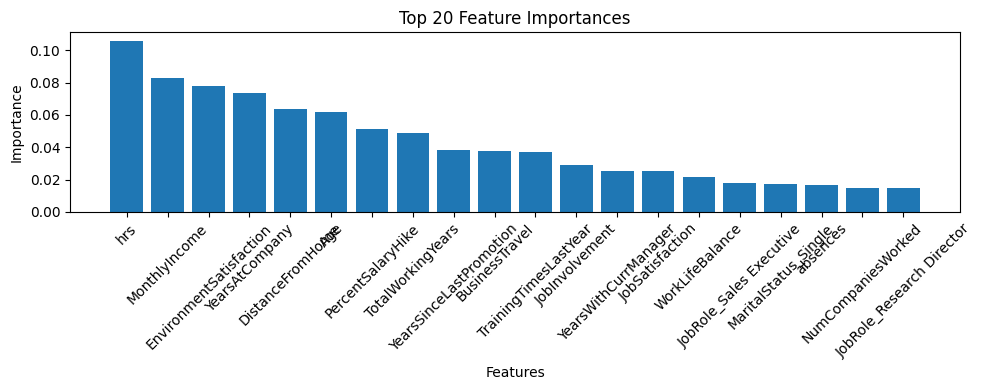

In [106]:
# Fit the pipeline
tree_pipeline.fit(X_train, y_train)

# Extract the trained tree model
tree_model = tree_pipeline.named_steps['tree']

# Retrieve feature names from the preprocessor
def get_feature_names(column_transformer):
    feature_names = []
    for name, transformer, columns in column_transformer.transformers_:
        if transformer == 'drop' or transformer is None:
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            # Get names for transformers like OneHotEncoder
            names = transformer.get_feature_names_out(columns)
        else:
            # Use original column names for other transformers
            names = columns
        feature_names.extend(names)
    return feature_names

# Get the feature names after preprocessing
feature_names = get_feature_names(tree_pipeline.named_steps['preprocessor'])

# Get feature importances from the decision tree
feature_importances = tree_model.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_feature_names = np.array(feature_names)[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

top_x = 20

# Print top features
print("Features sorted by importance:")
for name, importance in zip(sorted_feature_names, sorted_importances):
    print(f"{name}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(10, 4))
plt.bar(sorted_feature_names[:top_x], sorted_importances[:top_x])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title(f'Top {top_x} Feature Importances')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Most Important Features:

* `hrs`: The number of hours employees work is the most influential feature. This make sense, as overwork or imbalance in work hours is often a key factor in burnout and attrition.
  
* `MonthlyIncome`: Salary plays a significant role, likely because dissatisfaction with pay or financial stress can contribute to employee turnover.
  
* `YearsAtCompany`: Longer tenure may have an importance in attrition, as employees with more years invested in the company might have stronger ties or stability, or maybe they are more prone to burnout due to prolonged exposure to workplace stress or dissatisfaction. Additionally, longer-serving employees might feel stagnant in their roles if opportunities for growth and advancement are limited, contributing to their decision to leave.

# 5. Optional Question: Feature selection for KNN

For feature selection we are going to follow the tutorial uploaded. First, we have to choose a score function that works with knn classificator but also on numeric and categorical data. Since chi2 is only valid for positive data and our numeric columns have negative entries, we are using **mutual_info_classif as the score function**.


In [107]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

#We are using the method proposed on the tutorial to select the best variables
selector = SelectKBest(score_func=lambda X, y: mutual_info_classif(X, y, random_state=NIA))


#Knn using the preprocessor with standard scaler
knn_selection = Pipeline(steps=[
    ('preprocessor', preprocessor_standard),
    ('select', selector),
    ('knn', knn) ])


We are going to test if there is any subset of features that give better results in the KNN algorithm compare to using the whole dataset. For that we are going to run a grid iterating each number of features selected from 1 to 44, which is the number of total variables after encoded. 

In [108]:
param_grid = {'select__k': list(range(1,44))} 
tune_select_scale_knn = GridSearchCV(knn_selection,
                                    param_grid,
                                    scoring='balanced_accuracy',
                                    cv=cv)

In [109]:
#Intermediata step: we have to code the target
y_train2 = y_train.map({'Yes': 1, 'No': 0})

In [110]:
#We run our grid for future selection
tune_select_scale_knn.fit(X_train, y_train2)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100544178, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ordinal',
                                                                         OrdinalEncoder(categories=[['Non-Travel',
                                                                                                     'Travel_Rarely',
                                                                                                     'Travel_Frequently']]),
                                                                         ['BusinessTravel']),
                                                                        ('binary',
                                                                         BinaryEncoder(),
                                                                         ['Gender']),
                                                                        ('nominal',
                                                                         OneHotEncoder(handle_unknown='ignore...
                                                                          'TotalWorkingYears',
                                                                          'TrainingTimesLastYear',
                                                                          'YearsAtCompany',
                                                                          'YearsSinceLastPromotion',
                                                                          'YearsWithCurrManager'])])),
                                       ('select',
                                        SelectKBest(score_func=<function <lambda> at 0x00000254BDC73550>)),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='balanced_accuracy')

We study which is the number of features selected that returns the best model and also we print its accuracy:


In [111]:
best_params = tune_select_scale_knn.best_params_
best_score = tune_select_scale_knn.best_score_

print(f"Best parameters: {best_params}")
print(f"Best balanced accuracy: {best_score:.4f}")

Best parameters: {'select__k': 43}
Best balanced accuracy: 0.6268


All the variables except one have been selected. Moreover, the balanced accuracy, which is 0.627. is really similar from the balanced accuracy from the knn algorithm with the whole dataset, that is 0.649. This high similarity suggests that the excluded variable provides redundant information to the model. Consequently, for this specific technique, it appears that this variable can be disregarded without significantly impacting the model's performance

In [112]:
best_estimators= tune_select_scale_knn.best_estimator_

print(f"Features selected: {best_estimators.named_steps['select'].get_support()}")

print(f"Locations where features selected: {np.where(best_estimators.named_steps['select'].get_support())}")


# Get the names of the best features
X_transformed = preprocessor_standard.fit_transform(X_train)
feature_names = []

#Since when we are enconding the variables, more variables are created we need to assign them a name before retrieving which are the best.
if hasattr(preprocessor_standard.named_transformers_['ordinal'], 'get_feature_names_out'):
    feature_names.extend(preprocessor_standard.named_transformers_['ordinal'].get_feature_names_out())
else:
    feature_names.extend(ordinal_columns)

feature_names.extend(binary_columns)  # Agregar columnas binarias manualmente

if hasattr(preprocessor_standard.named_transformers_['nominal'], 'get_feature_names_out'):
    feature_names.extend(preprocessor_standard.named_transformers_['nominal'].get_feature_names_out())
else:
    feature_names.extend(nominal_columns)

feature_names.extend(numeric_columns)  # Agregar columnas numéricas

# To verify that the number of features we have named in this step remains consistent to the total number of features
assert len(feature_names) == X_transformed.shape[1], "The number of features does not match."


selected_features = best_estimators.named_steps['select'].get_feature_names_out(feature_names)
print(f"Selected features: {selected_features}")


not_selected_mask = ~best_estimators.named_steps['select'].get_support()
not_selected_features = [feature_names[i] for i in range(len(feature_names)) if not_selected_mask[i]]
print(f"Not selected features: {not_selected_features}")

Features selected: [ True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Locations where features selected: (array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43]),)
Selected features: ['BusinessTravel' 'Department_Human Resources'
 'Department_Research & Development' 'Department_Sales'
 'JobRole_Healthcare Representative' 'JobRole_Human Resources'
 'JobRole_Laboratory Technician' 'JobRole_Manager'
 'JobRole_Manufacturing Director' 'JobRole_Research Director'
 'JobRole_Research Scientist' 'JobRole_Sales Executive'
 'JobRole_Sales Representative' 'EducationField_Human Resources'
 'EducationField_Life Sciences' 'EducationField_Marketing'
 '

This results show that the variables that has been dropped is the Gender feature; which may imply that the gender hast little influence on our target and should not be taken into account to compute the distances between observation for this algorithm.

To assess the consistency of our results, this technique was rerun with other random seeds. It was surprising that the results differ a lot from each iteration, for example some results drop almost half of the coded variables from the dataset. In most of the instances, it can be seen that some categorical variables have categories that were included and selected as important but other categories from the same variable were not selected.  This would imply that while a categorical variable would help us classify the attrition, some of their categories may impact our target and other categories not. In these cases, an interesting next step for future approaches could be merging the categories that are not relevant into one category in order to reduce noise in the model and enhance its predictive accuracy by focusing on the most impactful categories.
